In [24]:
import numpy as np
import random
import torch
import torch.nn.functional as F
import timm
from src.adversarial import fgsm
from src.utils import tensor_imshow, load_image, get_standard_transforms
from config import settings, load_in1k_labels

Let's look only at resnet models trained on imagenet1k for now...

In [25]:

classes = load_in1k_labels()
timm.list_models(["resnet*" "*in1k"], pretrained=True)[:20]

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k']

Load a relevant model

In [26]:
model = timm.create_model("resnet18.a1_in1k", pretrained=True)
model.to(settings.device)
model.eval()
assert model.num_classes == 1000

Load and transform example image

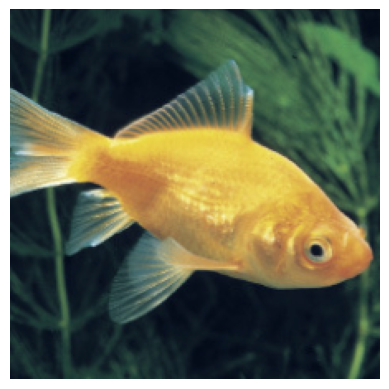

In [27]:
image_paths = settings.images_path.glob("*.JPEG")
transforms = get_standard_transforms()
original_image = load_image(next(image_paths))

# Transform and add batch dimension
original_image = transforms(original_image).unsqueeze(0)

tensor_imshow(original_image)

Run original through model and check prediction

In [28]:
output = model(original_image)

prob, class_idx = torch.max(F.softmax(output, dim=1), 1)
print(f"Original prediction: '{classes[class_idx.item()]}' (probability: {prob.item():.2f})")

Original prediction: 'goldfish, Carassius auratus' (probability: 1.00)


Run FQSM attack for different values of epsilon

In [29]:
target_class = random.randint(a=0, b=1000)
print(f"Targetting class: '{classes[target_class]}'")

for epsilon in np.arange(0.05, 0.95, 0.05):
    perturbed_image = fgsm(model, original_image, target_class=target_class, epsilon=epsilon)
    perturbed_pred, class_idx = torch.max(F.softmax(model(perturbed_image), dim=1), 1)
    print(f"[Epsilon: {epsilon:.2f}] Perturbed prediction: '{classes[class_idx.item()]}' (probability: {prob.item():.2f})")

Targetting class: 'suit, suit of clothes'
[Epsilon: 0.05] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.10] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.15] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.20] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.25] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.30] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.35] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.40] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.45] Perturbed prediction: 'brain coral' (probability: 1.00)
[Epsilon: 0.50] Perturbed prediction: 'brain coral' (probability: 1.00)
[Epsilon: 0.55] Perturbed prediction: 'brain coral' (probability: 1.00)
[Epsilon: 0.60] Perturbed prediction: 

Some weird things happening here, maybe too difficult to do in one step for 1000 classes? 